In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyexpat import features

sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from catboost import CatBoostClassifier, Pool

In [ ]:
pd.set_option('display.float_format', '{:,.2f}'.format)


 Чтение данных. Данные взяты из отчета [Дашбоард продаж AB](https://powerbi.data.lmru.tech/reports/powerbi/%D0%9E%D1%82%D1%87%D0%B5%D1%82%D1%8B%20Power%20BI/%D0%9B%D0%9C%20%D0%9F%D0%A0%D0%9E/%D0%94%D0%B0%D1%88%D0%B1%D0%BE%D1%80%D0%B4%20%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6%D0%B8%20%D0%90%D0%92). <br>
 Данные взяты только по продажам через b2b портал


Описание данных
- acive_clients - активная клиентская база
- gmv - объём продаж , руб
- gmv_per_customer - средний gmv на клиента
- gmv_units - количество проданных единиц товара
- average_bill - средний чек
- number_orders - количество заказов
- year - год
- month - месяц
- week - неделя
- date - дата



In [ ]:
gmv = pd.read_excel('et/gmv .xlsx', skiprows=2)
active_clients = pd.read_excel('et/active_clients_base.xlsx', skiprows=2)
gmv_per_customer = pd.read_excel('et/gmv_per_customer.xlsx', skiprows=2)
gmv_units = pd.read_excel('et/gmv_units.xlsx', skiprows=2)
average_bill = pd.read_excel('et/mean_check.xlsx', skiprows=2)
number_orders = pd.read_excel('et/voluem_.orders.xlsx', skiprows=2)


Информация о датафрейме

In [ ]:
print(f'Тип данных: '
      f'\n{gmv.dtypes}'
      f'\nShape: {gmv.shape}'
      f'\n Nan:'
      f'\n {gmv.isna().sum()}')

Тип данных: 
Год                    int64
Месяц                float64
Неделя                object
Дата          datetime64[ns]
Показатель           float64
dtype: object
Shape: (594, 5)
 Nan:
 Год           0
Месяц         0
Неделя        0
Дата          0
Показатель    0
dtype: int64


In [ ]:
gmv.tail(10)

,Год,Месяц,Неделя,Дата,Показатель
584,2024,"2,024.08",2024.w34,2024-08-22,"5,832,042.50"
585,2024,"2,024.08",2024.w34,2024-08-23,"5,562,394.46"
586,2024,"2,024.08",2024.w34,2024-08-24,"2,761,331.70"
587,2024,"2,024.08",2024.w34,2024-08-25,"2,181,533.39"
588,2024,"2,024.08",2024.w35,2024-08-26,"4,735,097.24"
589,2024,"2,024.08",2024.w35,2024-08-27,"6,350,600.56"
590,2024,"2,024.08",2024.w35,2024-08-28,"6,111,320.69"
591,2024,"2,024.08",2024.w35,2024-08-29,"6,521,139.29"
592,2024,"2,024.08",2024.w35,2024-08-30,"5,493,522.97"
593,2024,"2,024.08",2024.w35,2024-08-31,"2,813,324.65"


Заменим названия столбцов и агрегируем данные

In [ ]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    df_name = [k for k, v in globals().items() if id(v) == id(df)][0]
    df.rename(columns={'Год' : 'year', 'Месяц' : 'month', 'Неделя' : 'week', 'Дата' : 'date', 'Показатель' : df_name}, inplace=True)
    return df

In [ ]:
rename_columns(gmv)
rename_columns(active_clients)
rename_columns(gmv_per_customer)
rename_columns(gmv_units)
rename_columns(average_bill)
rename_columns(number_orders)

,year,month,week,date,number_orders
0,2023,"2,023.01",2023.w02,2023-01-11,4
1,2023,"2,023.01",2023.w02,2023-01-12,1
2,2023,"2,023.01",2023.w02,2023-01-13,3
3,2023,"2,023.01",2023.w03,2023-01-16,6
4,2023,"2,023.01",2023.w03,2023-01-17,13
...,...,...,...,...,...
589,2024,"2,024.08",2024.w35,2024-08-27,392
590,2024,"2,024.08",2024.w35,2024-08-28,382
591,2024,"2,024.08",2024.w35,2024-08-29,347
592,2024,"2,024.08",2024.w35,2024-08-30,344


In [ ]:
df_merged = pd.merge(active_clients, gmv, on=['year','month','week','date'], how='outer')

In [ ]:
df_merged = pd.merge(df_merged, gmv_per_customer, on=['year','month','week','date'], how='outer')
df_merged = pd.merge(df_merged, gmv_units, on=['year','month','week','date'], how='outer')
df_merged = pd.merge(df_merged, average_bill, on=['year','month','week','date'], how='outer')
df_merged = pd.merge(df_merged, number_orders, on=['year','month','week','date'], how='outer')

In [ ]:
df_merged.head()

,year,month,week,date,active_clients,gmv,gmv_per_customer,gmv_units,average_bill,number_orders
0,2023,"2,023.01",2023.w02,2023-01-11,3,"49,960.00","16,653.33",59.00,"12,490.00",4
1,2023,"2,023.01",2023.w02,2023-01-12,1,"3,905.00","3,905.00",27.00,"3,905.00",1
2,2023,"2,023.01",2023.w02,2023-01-13,2,"23,048.00","11,524.00",199.00,"7,682.67",3
3,2023,"2,023.01",2023.w03,2023-01-16,4,"65,217.00","16,304.25",161.00,"10,869.50",6
4,2023,"2,023.01",2023.w03,2023-01-17,5,"187,437.00","37,487.40",642.00,"14,418.23",13


In [ ]:
print(f'Тип данных: '
      f'\n{df_merged.dtypes}'
      f'\nShape: {df_merged.shape}'
      f'\n Nan:'
      f'\n {df_merged.isna().sum()}')

Тип данных: 
year                         int64
month                      float64
week                        object
date                datetime64[ns]
active_clients               int64
gmv                        float64
gmv_per_customer           float64
gmv_units                  float64
average_bill               float64
number_orders                int64
dtype: object
Shape: (594, 10)
 Nan:
 year                0
month               0
week                0
date                0
active_clients      0
gmv                 0
gmv_per_customer    0
gmv_units           0
average_bill        0
number_orders       0
dtype: int64


In [ ]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
year,594.00,"2,023.41","2,023.00","2,023.00","2,023.00","2,024.00","2,024.00",0.49
month,594.00,"2,023.47","2,023.01","2,023.06","2,023.11","2,024.04","2,024.08",0.48
date,594,2023-11-07 20:55:45.454545408,2023-01-11 00:00:00,2023-06-12 06:00:00,2023-11-07 12:00:00,2024-04-04 18:00:00,2024-08-31 00:00:00,NaN
active_clients,594.00,74.70,1.00,28.00,64.50,113.00,198.00,52.83
gmv,594.00,"2,383,888.69","1,266.00","828,349.43","2,004,397.04","3,569,723.24","7,859,251.65","1,838,354.24"
gmv_per_customer,594.00,"30,739.95","1,266.00","25,494.48","30,490.37","35,519.47","117,388.27","10,726.63"
gmv_units,594.00,"7,579.46",2.00,"2,613.75","6,435.00","11,411.75","44,383.00","5,970.14"
average_bill,594.00,"19,286.91","1,266.00","15,528.85","17,976.18","21,431.43","92,224.04","7,504.61"
number_orders,594.00,130.26,1.00,42.00,106.00,203.75,392.00,101.60


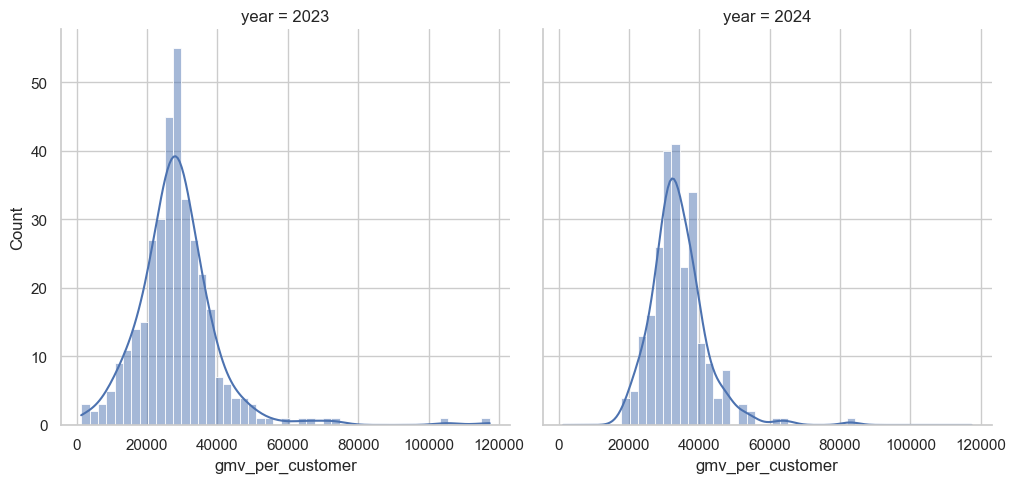

In [ ]:
sns.displot(data=df_merged, x="gmv_per_customer", kde=True, col="year", col_wrap=3)


In [ ]:
df_merged.columns.to_list()

['year',
 'month',
 'week',
 'date',
 'active_clients',
 'gmv',
 'gmv_per_customer',
 'gmv_units',
 'average_bill',
 'number_orders']

Получим массив признаков и разобьем на тестовую и обучающую выборки

In [ ]:
X = df_merged[['active_clients', 'gmv_per_customer', 'gmv_units', 'average_bill', 'number_orders']]

In [ ]:
y = df_merged['gmv']

In [ ]:
X.dtypes

active_clients        int64
gmv_per_customer    float64
gmv_units           float64
average_bill        float64
number_orders         int64
dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

Метрики оценки модели

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MSE: 19717146543.94


In [ ]:
print(f'R-squared: {rf.score(X_test, y_test):.2f}')


R-squared: 0.99


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}') # Mean Absolute Error (mae)

MAE: 93542.14


In [ ]:
df_merged.loc[df_merged['year'] == 2024].sort_values(by='date', ascending=False).head(3)

,year,month,week,date,active_clients,gmv,gmv_per_customer,gmv_units,average_bill,number_orders
593,2024,"2,024.08",2024.w35,2024-08-31,68,"2,813,324.65","41,372.42","5,760.00","24,896.68",113
592,2024,"2,024.08",2024.w35,2024-08-30,168,"5,493,522.97","32,699.54","17,560.80","16,394.82",344
591,2024,"2,024.08",2024.w35,2024-08-29,175,"6,521,139.29","37,263.65","16,297.50","18,862.10",347


Предсказание прогноза с помощью новых данных

In [ ]:
new_data = pd.DataFrame({'active_clients': [100], 'gmv_per_customer': [45000], 'gmv_units': [6000], 'average_bill': [26000], 'number_orders': [120]})
new_pred = rf.predict(new_data)
print(f'Прогноз  значения GMV: {new_pred[0]:.2f}')

Прогноз  значения GMV: 3371820.63


Оценим важность признаков

In [ ]:
feature_importances = rf.feature_importances_

In [ ]:
features = X.columns
feature_importances_df = pd.DataFrame({'feature': features, 'importance': feature_importances})

In [ ]:
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

<Axes: xlabel='importance', ylabel='feature'>

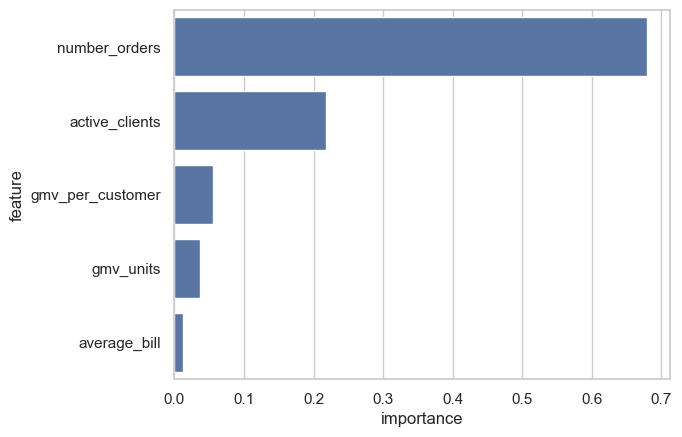

In [ ]:
sns.barplot(x='importance', y='feature', data=feature_importances_df)

СР gmv  в 24 году и 23 году


In [ ]:
df_merged.loc[df_merged['year'] == 2024].gmv.mean().round(2)

3789133.97

In [ ]:
df_merged.loc[df_merged['year'] == 2023].gmv.mean().round(2)

1411026.58

СР кол-во заказов  в 24 году и 23 году

In [ ]:
df_merged.loc[df_merged['year'] == 2024].number_orders.mean().round(2)

205.26

In [ ]:
df_merged.loc[df_merged['year'] == 2023].number_orders.mean().round(2)

78.34

In [ ]:
print("Средние значения features и GMV в 24 г:"
      f'\n GMV: {df_merged.loc[df_merged["year"] == 2024].gmv.mean().round(2)}'
      f'\n number_orders: {df_merged.loc[df_merged["year"] == 2024].number_orders.mean().round(2)}'
      f'\n gmv_per_customer: {df_merged.loc[df_merged["year"] == 2024].gmv_per_customer.mean().round(2)}'
      f'\n average_bill: {df_merged.loc[df_merged["year"] == 2024].average_bill.mean().round(2)}'
      f'\n gmv_units: {df_merged.loc[df_merged["year"] == 2024].gmv_units.mean().round(2)}'
      f'\n active_clients: {df_merged.loc[df_merged["year"] == 2024].active_clients.mean().round(2)}')

Средние значения features и GMV в 24 г:
 GMV: 3789133.97
 number_orders: 205.26
 gmv_per_customer: 34070.31
 average_bill: 19925.11
 gmv_units: 11807.49
 active_clients: 113.57


Прогнозное значение GMV  при росте АКБ +20% и росте кол-ва заказов +50%

In [ ]:
new_data = pd.DataFrame({'active_clients': [114 *1.2 ], 'gmv_per_customer': [34070], 'gmv_units': [11807], 'average_bill': [19925], 'number_orders': [205 * 1.5]})
new_pred = rf.predict(new_data)
print(f'Прогноз  значения GMV: {new_pred[0]:.2f}')

Прогноз  значения GMV: 5170143.69


In [ ]:
mean_gmv_24 = df_merged.loc[df_merged["year"] == 2024].gmv.mean().round(2)


In [ ]:
 mean_gmv_24 / new_pred

array([0.73288756])

In [ ]:
train_data = df_merged[['active_clients', 'gmv_per_customer', 'gmv_units', 'average_bill', 'number_orders']]

In [ ]:
import numpy as np
from catboost import Pool, CatBoostRegressor
# initialize data
train_data = np.random.randint(0,
                               100,
                               size=(100, 10))
train_label = np.random.randint(0,
                                1000,
                                size=(100))
test_data = np.random.randint(0,
                              100,
                              size=(50, 10))
# initialize Pool
train_pool = Pool(train_data,
                  train_label,
                  cat_features=[0,2,5])
test_pool = Pool(test_data,
                 cat_features=[0,2,5])

# specify the training parameters
model = CatBoostRegressor(iterations=2,
                          depth=2,
                          learning_rate=1,
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(test_pool)
print(preds)